# Zipline test to buy after down Monday

Start with the imports.

You’ll use pandas_datareader to get data to compare your strategy with the S&P 500, matplotlib for charting, and PyFolio for performance analysis.

In [41]:
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt

from zipline import run_algorithm
from zipline.api import order_target, record, symbol
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

import pyfolio as pf

import warnings
warnings.filterwarnings('ignore')

Since you’re building the backtest in Jupyter Notebook, you need to load the Zipline “magics.” Running this lets you run the Zipline command line right in your Notebook.

In [42]:
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


I already uploaded quandl data through 2018 in an earlier session, so I will skip this step

In [61]:
# %env QUANDL_API_KEY your_key_here
# ! zipline ingest -b quandl

You will see Zipline working its magic to download the data and package it into highly efficient data stores.

Every Zipline strategy must have an initialize function. This is run at the beginning of the strategy.

Here, you set a counter to track the days, the symbol to trade, and set the commission and slippage models.

In [44]:
def initialize(context):
    context.i = 0
    context.asset = symbol("MSFT")

    context.set_commission(commission.PerShare(cost=0.01))
    context.set_slippage(slippage.FixedSlippage(spread=0.01))

Every Zipline strategy must also have a handle_data function.

This function is run at every “bar.” Depending on your data, it might run every minute or day. handle_data is where your strategy logic lives.

The strategy is to buy if Monday's close is down from the previous close and sell 4 days later.

In [50]:
def handle_data(context, data):
    # Skip first 6 days to make sure there is a previous day for the first Monday
    context.i += 1
    if context.i < 6:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    prices = data.history(
        context.asset, 
        "price", 
        bar_count=6,
        frequency="1d"
    )
    buy_setup = (prices.index.dayofweek[-1] == 0) & (prices[-1] < prices[-2])
    
    sell_setup = (prices.index.dayofweek[-5] == 0) & (prices[-5] < prices[-6])
    
    # Trading logic
    if buy_setup:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif sell_setup:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(
        MSFT=data.current(context.asset, "price"),
        buy_setup=buy_setup,
        sell_setup=sell_setup,
    )

Use the counter to make sure there is enough data to look back a week.

Buy after a down Monday and sell 4 trading days later

In [51]:
def analyze(context, perf):
    # Simple plot of the portfolio value
    perf.portfolio_value.plot()

The first step is to define the start and end dates.

In [52]:
start = pd.Timestamp('2000')
end = pd.Timestamp('2018')

Then, get data to compare your strategy with the S&P 500.

In [53]:
sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()

Finally, run the backtest.

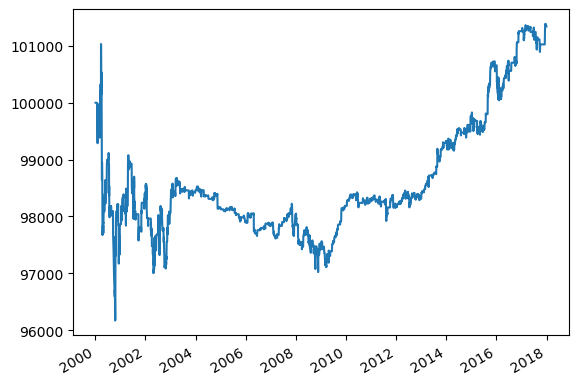

In [54]:
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    handle_data=handle_data,
    analyze=analyze,
    capital_base=100000,
    benchmark_returns=benchmark_returns,
    bundle="quandl",
    data_frequency="daily",
)

In [58]:
perf[95:107]

,period_open,period_close,ending_exposure,starting_value,ending_value,starting_cash,ending_cash,returns,portfolio_value,longs_count,...,treasury_period_return,trading_days,period_label,algorithm_period_return,algo_volatility,benchmark_period_return,benchmark_volatility,MSFT,buy_setup,sell_setup
2000-05-18 00:00:00+00:00,2000-05-18 13:31:00+00:00,2000-05-18 20:00:00+00:00,0.0,0.0,0.0,98404.0,98404.0,0.000000,98404.0,0,...,0.0,96,2000-05,-0.015960,0.040394,0.0,0.0,66.19,False,False
2000-05-19 00:00:00+00:00,2000-05-19 13:31:00+00:00,2000-05-19 20:00:00+00:00,0.0,0.0,0.0,98404.0,98404.0,0.000000,98404.0,0,...,0.0,97,2000-05,-0.015960,0.040184,0.0,0.0,65.06,False,False
2000-05-22 00:00:00+00:00,2000-05-22 13:31:00+00:00,2000-05-22 20:00:00+00:00,0.0,0.0,0.0,98404.0,98404.0,0.000000,98404.0,0,...,0.0,98,2000-05,-0.015960,0.039977,0.0,0.0,64.19,True,False
2000-05-23 00:00:00+00:00,2000-05-23 13:31:00+00:00,2000-05-23 20:00:00+00:00,6319.0,0.0,6319.0,98404.0,92083.5,-0.000015,98402.5,1,...,0.0,99,2000-05,-0.015975,0.039773,0.0,0.0,63.19,False,False
2000-05-24 00:00:00+00:00,2000-05-24 13:31:00+00:00,2000-05-24 20:00:00+00:00,6556.0,6319.0,6556.0,92083.5,92083.5,0.002408,98639.5,1,...,0.0,100,2000-05,-0.013605,0.039781,0.0,0.0,65.56,False,False
2000-05-25 00:00:00+00:00,2000-05-25 13:31:00+00:00,2000-05-25 20:00:00+00:00,6150.0,6556.0,6150.0,92083.5,92083.5,-0.004116,98233.5,1,...,0.0,101,2000-05,-0.017665,0.040078,0.0,0.0,61.50,False,False
2000-05-26 00:00:00+00:00,2000-05-26 13:31:00+00:00,2000-05-26 20:00:00+00:00,6144.0,6150.0,6144.0,92083.5,92083.5,-0.000061,98227.5,1,...,0.0,102,2000-05,-0.017725,0.039880,0.0,0.0,61.44,False,True
2000-05-30 00:00:00+00:00,2000-05-30 13:31:00+00:00,2000-05-30 20:00:00+00:00,0.0,6144.0,0.0,92083.5,98420.0,0.001960,98420.0,0,...,0.0,103,2000-05,-0.015800,0.039824,0.0,0.0,63.38,False,False
2000-05-31 00:00:00+00:00,2000-05-31 13:31:00+00:00,2000-05-31 20:00:00+00:00,0.0,0.0,0.0,98420.0,98420.0,0.000000,98420.0,0,...,0.0,104,2000-05,-0.015800,0.039631,0.0,0.0,62.56,False,False
2000-06-01 00:00:00+00:00,2000-06-01 13:31:00+00:00,2000-06-01 20:00:00+00:00,0.0,0.0,0.0,98420.0,98420.0,0.000000,98420.0,0,...,0.0,105,2000-06,-0.015800,0.039440,0.0,0.0,64.56,False,False


Now that the backtest is finished, use PyFolio to get a breakdown of the results.

In [59]:
returns, positions, transactions = \
    pf.utils.extract_rets_pos_txn_from_zipline(perf)

This creates a full tear sheet based on your backtest results. There’s a ton of information here, but here are the highlights:

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.81,2000-03-23,2000-10-17,2016-10-24,4328
1,0.71,2000-01-24,2000-02-02,2000-03-09,34
2,0.46,2017-03-01,2017-09-26,2017-12-11,204
3,0.30,2000-03-10,2000-03-14,2000-03-17,6
4,0.21,2017-01-11,2017-02-02,2017-03-01,36


Stress Events,mean,min,max
Dotcom,-0.02%,-1.53%,0.86%
Lehman,0.00%,-0.15%,0.08%
9/11,-0.01%,-0.32%,0.23%
US downgrade/European Debt Crisis,-0.00%,-0.14%,0.10%
Fukushima,-0.00%,-0.02%,0.01%
US Housing,-0.00%,-0.17%,0.11%
EZB IR Event,-0.00%,-0.04%,0.03%
Aug07,0.00%,-0.03%,0.07%
Mar08,-0.00%,-0.06%,0.05%
Sept08,-0.00%,-0.15%,0.07%


Top 10 long positions of all time,max
sid,
MSFT,11.07%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
MSFT,11.07%


Summary stats,All trades,Long trades
Total number of round_trips,385.00,385.00
Percent profitable,0.54,0.54
Winning round_trips,209.00,209.00
Losing round_trips,175.00,175.00
Even round_trips,1.00,1.00


PnL stats,All trades,Long trades
Total profit,$2111.80,$2111.80
Gross profit,$23581.60,$23581.60
Gross loss,$-21469.80,$-21469.80
Profit factor,$1.10,$1.10
Avg. trade net profit,$5.49,$5.49
Avg. winning trade,$112.83,$112.83
Avg. losing trade,$-122.68,$-122.68
Ratio Avg. Win:Avg. Loss,$0.92,$0.92
Largest winning trade,$1168.00,$1168.00
Largest losing trade,$-1345.00,$-1345.00


Duration stats,All trades,Long trades
Avg duration,6 days 09:32:15.584415584,6 days 09:32:15.584415584
Median duration,6 days 00:00:00,6 days 00:00:00
Longest duration,19 days 00:00:00,19 days 00:00:00
Shortest duration,5 days 21:00:00,5 days 21:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,NaN,NaN
Avg returns winning,NaN,NaN
Avg returns losing,NaN,NaN
Median returns all round_trips,NaN,NaN
Median returns winning,NaN,NaN
Median returns losing,NaN,NaN
Largest winning trade,NaN,NaN
Largest losing trade,NaN,NaN


Symbol stats,MSFT
Avg returns all round_trips,NaN
Avg returns winning,NaN
Avg returns losing,NaN
Median returns all round_trips,NaN
Median returns winning,NaN
Median returns losing,NaN
Largest winning trade,NaN
Largest losing trade,NaN


Profitability (PnL / PnL total) per name,
symbol,
MSFT,100.00%


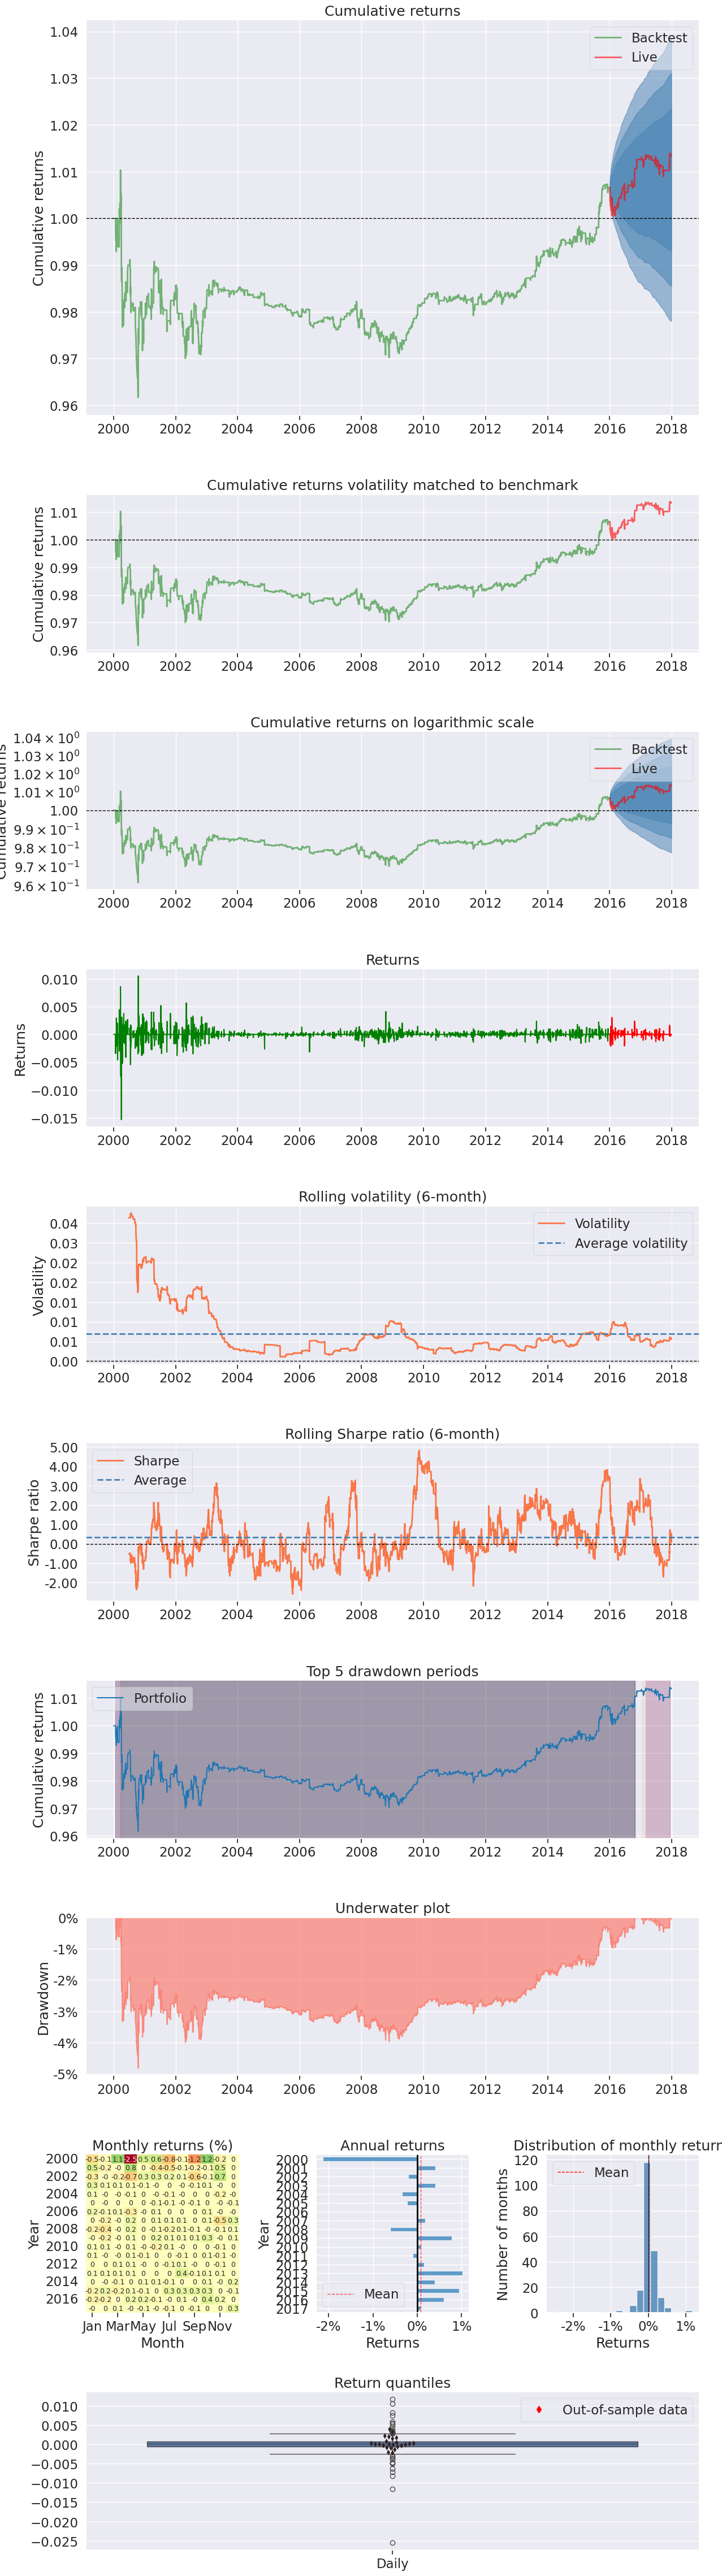

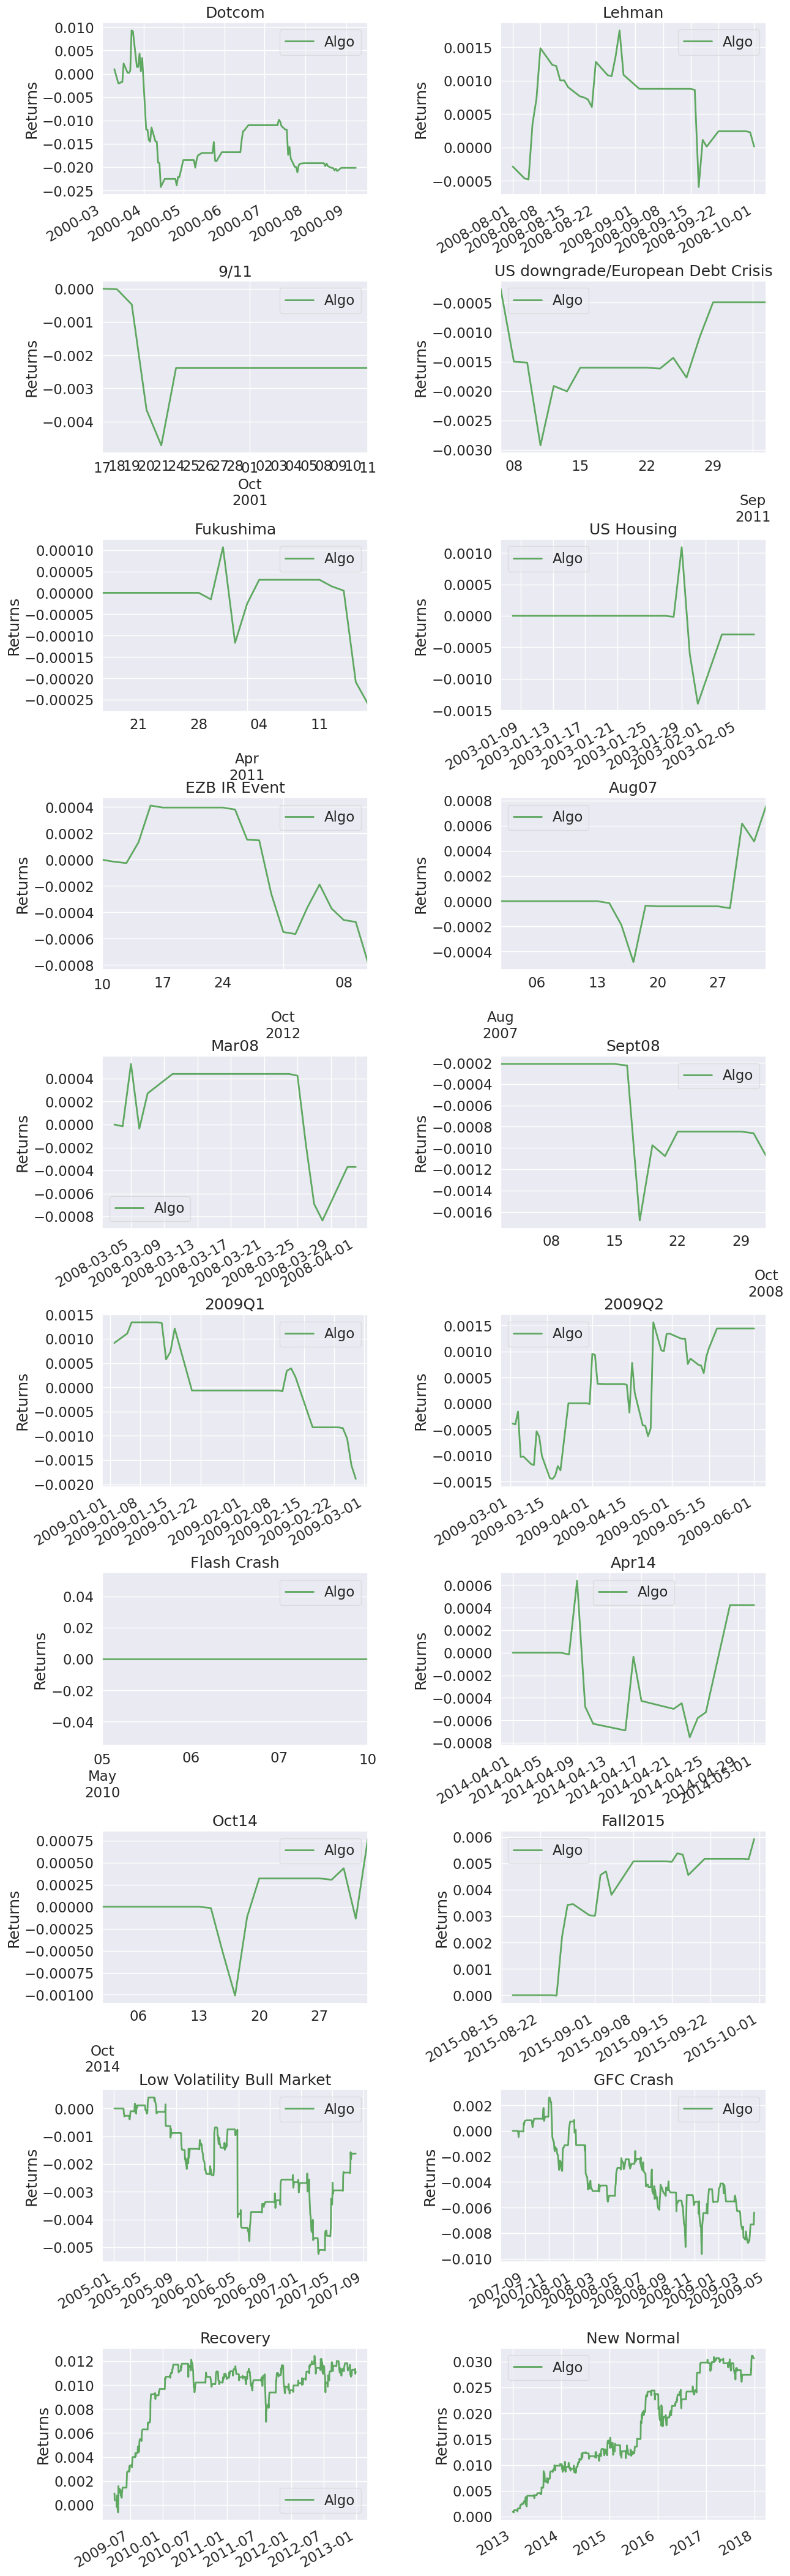

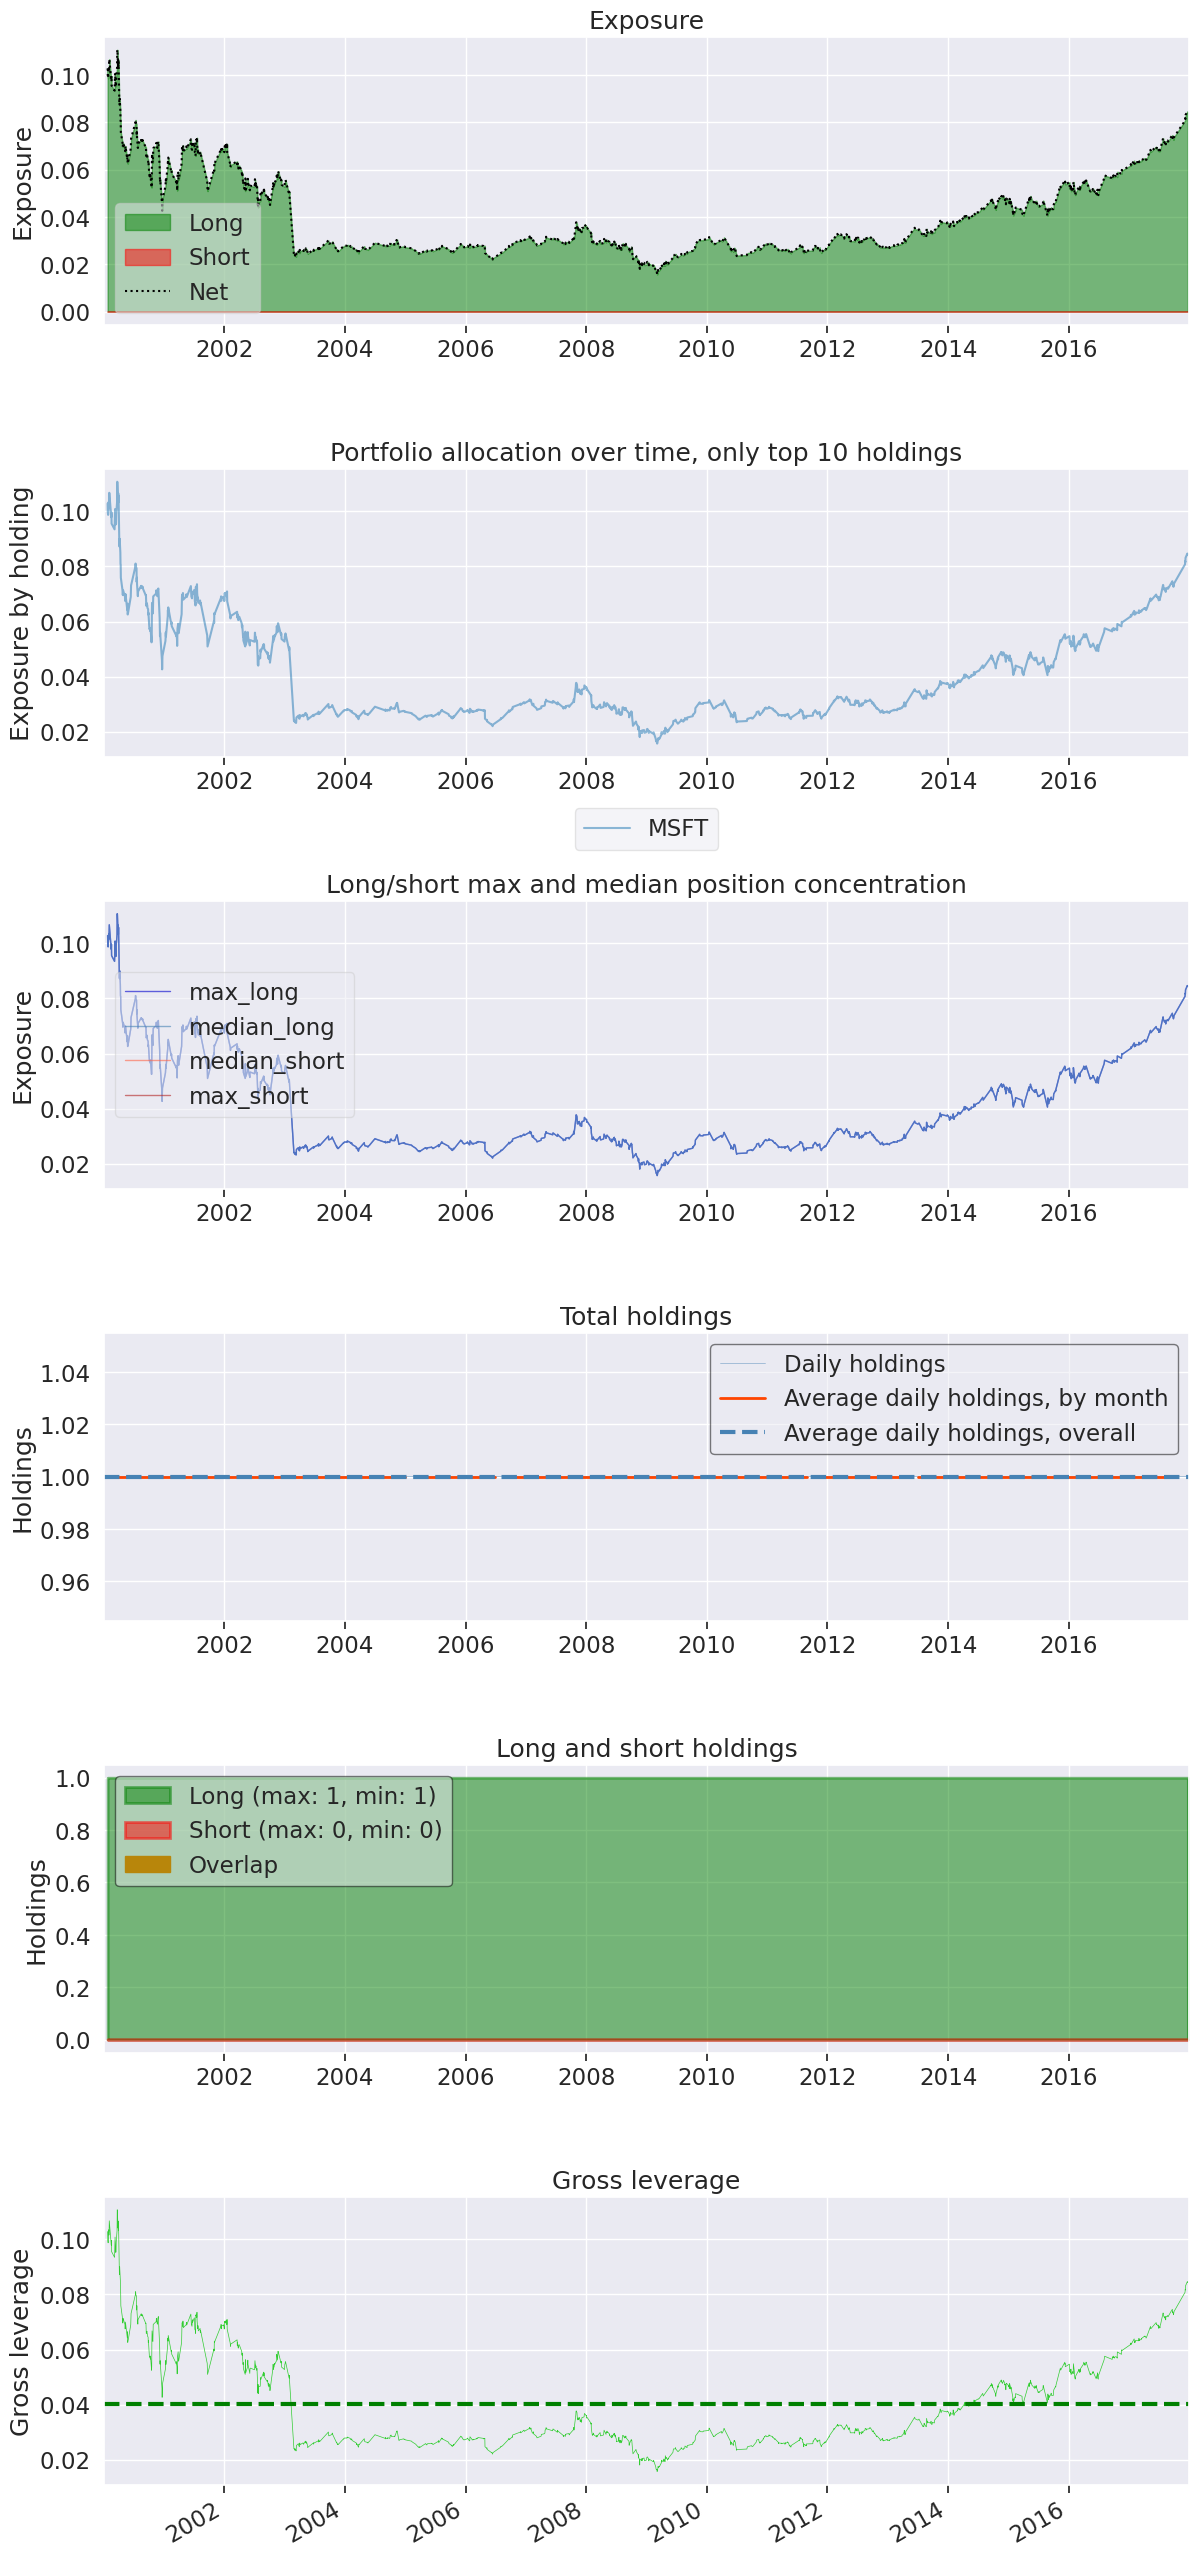

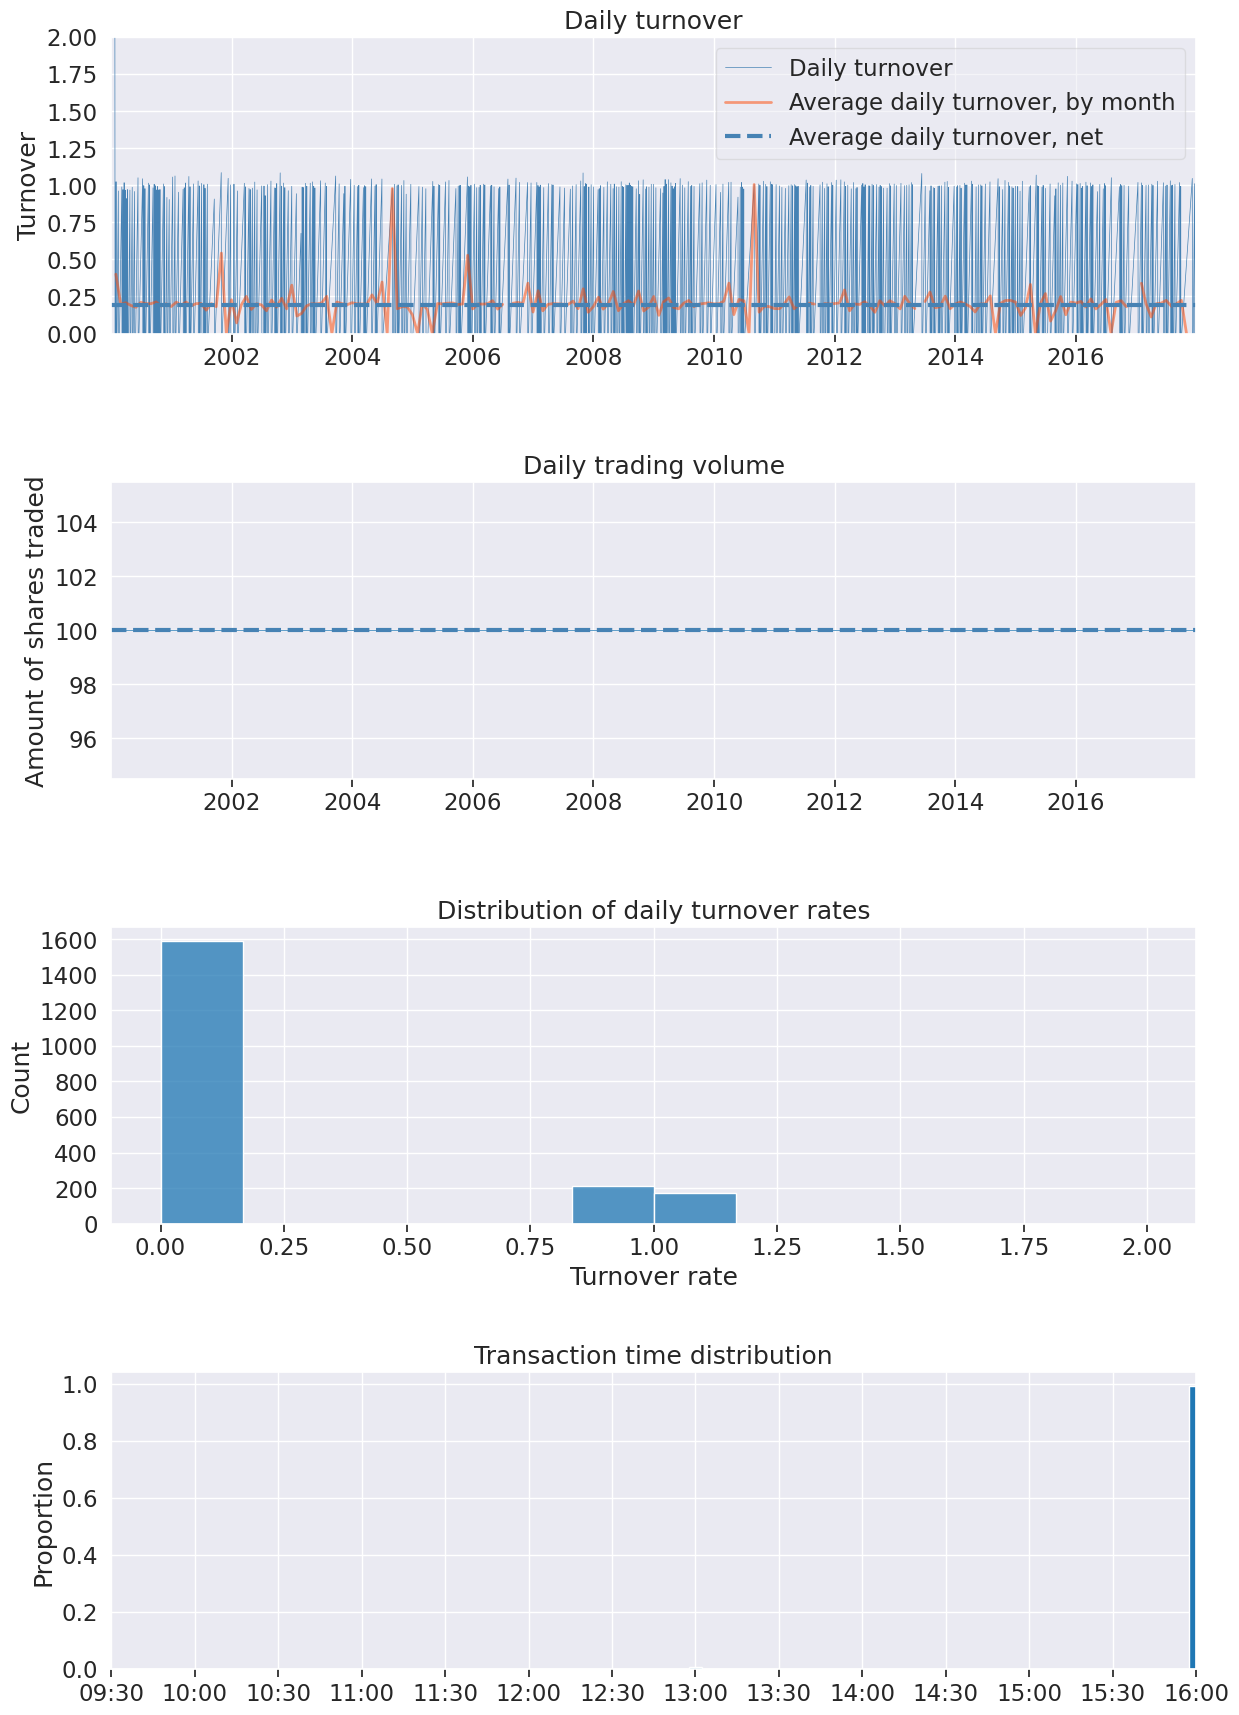

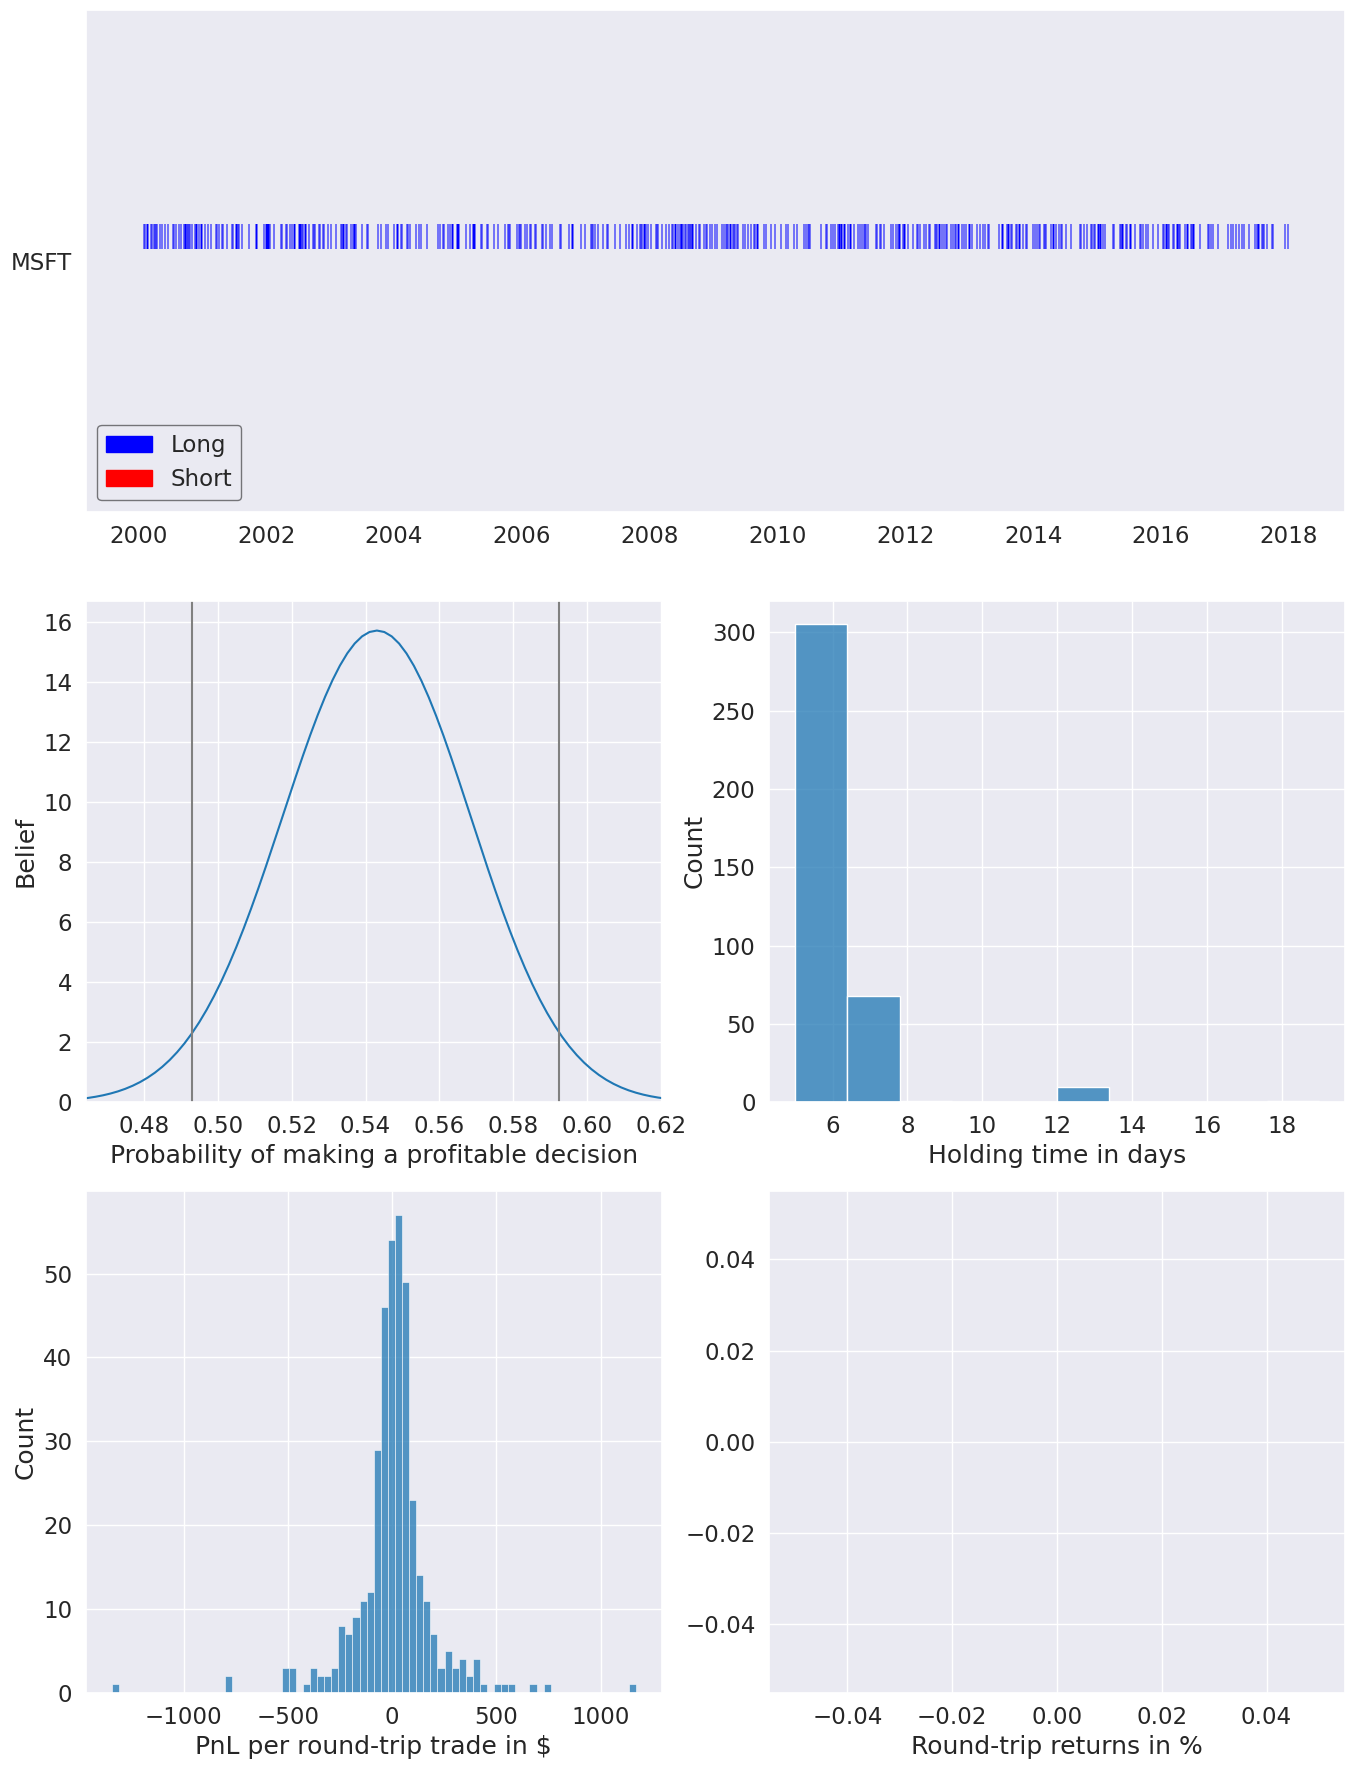

In [60]:
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date="2016-01-01",
    round_trips=True,
)